In [2]:
from torchvision.datasets import FakeData
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.datasets import CelebA
import os
from accelerate import Accelerator
import segmentation_models_pytorch as smp

from dataclasses import dataclass


/home/jsooh/ssd/t5/envs/conda_envs/aging/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

### Fake Data

In [4]:
# Reuse the same transformations
transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5]),
])

# Create 100 random fake RGB images at 256x256
smoke_ds = FakeData(
    size=100,
    image_size=(3, 256, 256),
    transform=transform,
    random_offset=0, # seed
)

# Wrap in a loader
smoke_loader = DataLoader(smoke_ds, batch_size=8, shuffle=True)

In [5]:
# data_dir = os.path.join(os.path.dirname(__file__), "..", "..", "data")
# path logic for notebook
data_dir = os.path.join(os.getcwd(), "..", "..", "data")

transform = T.Compose([
    T.CenterCrop(178),
    T.Resize(256),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5]),
])

# dataset_train = CelebA(
#     root=str(data_dir),
#     split="train",
#     download=True,
#     transform=transform,
# )

# dataset_val= CelebA(
#     root=str(data_dir),
#     split="valid",
#     download=True,
#     transform=transform,
# )

# dataset_test = CelebA(
#     root=str(data_dir),
#     split="test",
#     download=True,
#     transform=transform,
# )

In [7]:
data_dir = os.path.join(os.getcwd(), "..", "..", "data")

full = CelebA(
    root=str(data_dir),
    split="all",
    download=True,
    transform=transform,
)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

In [10]:
# data_dir = os.path.join(os.path.dirname(__file__), "..", "..", "data")
# path logic for notebook
data_dir = os.path.join(os.getcwd(), "..", "..", "data")

transform = T.Compose([
    T.CenterCrop(178),
    T.Resize(256),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5]),
])

def make_unpaired_loader(root, split, batch_size=4, num_workers=2, limit=None, transform=transform):
    # download split
    full = CelebA(
        root=root,
        split=split,
        download=True,
        transform=transform,
    )
    
    # locate the "Young" attribute index
    young_attr_i = full.attr_names.index("Young")
    attrs = full.attr
    print(full.attr_names)
    print(attrs)
    # split indices
    young_idx = (attrs[:, young_attr_i] == 1).nonzero(as_tuple=True)[0]
    old_idx = (attrs[:, young_attr_i] == 1).nonzero(as_tuple=True)[0]
    
    # limit each domain samples
    if limit is not None:
        gen = torch.Generator()
        perm_y = torch.randperm(len(young_idx), generator=gen)[:limit]
        perm_o = torch.randperm(len(old_idx), generator=gen)[:limit]
        young_idx = young_idx[perm_y]
        old_idx = old_idx[perm_o]
        
    # build subsets
    young_ds = Subset(full, young_idx)
    old_ds = Subset(full, old_idx)
    
    # unpaird wrapper
    @dataclass
    class Unpaired(Dataset):
        a: Dataset
        b: Dataset
        
        def __len__(self) -> int:
            return max(len(self.a), len(self.b))

        def __getitem__(self, idx: int):
            x, _ = self.a[idx % len(self.a)]
            y, _ = self.b[idx % len(self.b)]
            return x, y
    
    paired = Unpaired(young_ds, old_ds)
    return DataLoader(
        paired, batch_size=batch_size, shuffle=(split=="train"),
        num_workers=num_workers, pin_memory=True, drop_last=(split=="train")
    )
    
train_loader = make_unpaired_loader(str(data_dir), "train", limit=100)
val_loader = make_unpaired_loader(str(data_dir), "valid", limit=20)
test_loader = make_unpaired_loader(str(data_dir), "test", limit=20)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

but Gdown can't. Please check connections and permissions.

In [ ]:
train_loader = DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=4, pin_memory=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


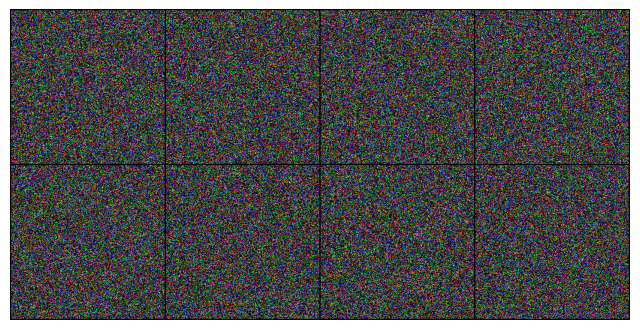

tensor([1, 6, 3, 9, 5, 7, 1, 3])


In [20]:
import torchvision

images,labels = next(iter(dataloader))

grid = torchvision.utils.make_grid(images, nrow=4, padding=2)

# plot
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
print(labels)

In [ ]:
young

## Models

In [7]:
# initilize the generators
# checkpoint="google/ddpm-celebahq-256" # 128 for smaller image input size
# G = UNet2DModel.from_pretrained(checkpoint, use_safetensors=False)
# F = UNet2DModel.from_pretrained(checkpoint, use_safetensors=False)

G = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet", # preload low-level filters
    in_channels=3, # RGB input
    classes=3, # RGB output
)

F = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet", # preload low-level filters
    in_channels=3, # RGB input
    classes=3, # RGB output
)

In [8]:
# Freeze encoder of model so that model can learn "aging" during the first epoch
for name, param in G.named_parameters():
    if (
        name.startswith("conv_in") or
        name.startswith("time_proj") or
        name.startswith("time_embedding") or
        name.startswith("down_blocks") or
        name.startswith("mid_block")
    ):
        param.requires_grad = False
        

for name, param in F.named_parameters():
    if (
        name.startswith("conv_in") or
        name.startswith("time_proj") or
        name.startswith("time_embedding") or
        name.startswith("down_blocks") or
        name.startswith("mid_block")
    ):
        param.requires_grad = False

# sanity check
print("Trainable param in G:")
for name, param in G.named_parameters():
    if not param.requires_grad:
        print(" ", name)

Trainable param in G:


In [9]:
G


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [10]:
# PatchGAN 70x70
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super().__init__()
        layers = [
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=ndf, 
                kernel_size=4, 
                stride=2, 
                padding=1),
            nn.LeakyReLU(0.2)
        ]
        nf = ndf
        for i in range(3):
            stride = 2 if i < 2 else 1
            layers += [
                nn.Conv2d(nf, nf*2, 4, stride, 1),
                nn.InstanceNorm2d(nf*2),
                nn.LeakyReLU(0.2)
            ]
            nf *= 2
        layers += [nn.Conv2d(nf, 1, 4, 1, 1)]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
model = PatchDiscriminator()
x = torch.randn(1, 3, 256, 256)
out = model(x)
print(out.shape)

torch.Size([1, 1, 30, 30])


In [12]:
DX = PatchDiscriminator()
DY = PatchDiscriminator()

DX

PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [13]:
# initlize the discriminator
DX = PatchDiscriminator()
DY = PatchDiscriminator()

# initilize the optimizers
LR = 2e-4
opt_G = optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), lr=LR, betas=(0.5,0.999))
opt_F = optim.Adam(filter(lambda p: p.requires_grad, F.parameters()), lr=LR, betas=(0.5,0.999))
opt_DX = optim.Adam(DX.parameters(), lr=LR, betas=(0.5,0.999))
opt_DY = optim.Adam(DY.parameters(), lr=LR, betas=(0.5,0.999))

# prepare (uses hf accelerate to move models o right device and wraps in optimzers too)
accelerator = Accelerator(mixed_precision="fp16")

G, F, DX, DY, opt_G, opt_F, opt_DX, opt_DY, dataloader = accelerator.prepare(
    G, F, DX, DY, opt_G, opt_F, opt_DX, opt_DY, dataloader
    # learning rate schedulers
) # everything lives on the GPU with automatic CPU fallback, distributed data parallel, mixed precision

## Train Logic

In [14]:
# loss functions and scalers
bce = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()
lambda_cyc = 10.0
lambda_id = 5.0

In [15]:
def perform_train_step(
    G, F, # generator models
    DX, DY, # discriminator models
    real_data,
    bce, l1, lambda_cyc, lambda_id, # loss functions and loss params
    opt_G, opt_F, # generator optimizers
    opt_DX, opt_DY # discriminator optimizers
):
    x, y = real_data
    # Generate fakes and reconstrucitons
    fake_x = F(y)
    fake_y = G(x)
    rec_x = F(fake_y)
    rec_y = G(fake_x)
    
    # ------ Update Discriminators ------
    # DX: real young vs fake young
    opt_DX.zero_grad(set_to_none=True) 
    real_logits = DX(x)
    real_targets = torch.ones_like(real_logits)
    real_loss = bce(real_logits, real_targets)
    
    fake_logits = DX(fake_x.detach())
    fake_targets = torch.zeros_like(fake_logits)
    fake_loss = bce(fake_logits, fake_targets)

    # DY loss + backprop + step
    loss_DX = 0.5 * (real_loss + fake_loss)
    accelerator.backward(loss_DX)
    opt_DX.step()
    # DY: real old vs fake old
    opt_DY.zero_grad(set_to_none=True) 
    real_logits = DY(y)
    real_targets = torch.ones_like(real_logits)
    real_loss = bce(real_logits, real_targets)
    
    fake_logits = DY(fake_y.detach())
    fake_targets = torch.zeros_like(fake_logits)
    fake_loss = bce(fake_logits, fake_targets)

    # DY loss + backprop + step
    loss_DY = 0.5 * (real_loss + fake_loss) # average loss to prevent discriminator learning "too quickly" compread to generators.
    accelerator.backward(loss_DY)
    opt_DY.step()
    
    # ------ Update Generators ------
    opt_G.zero_grad(set_to_none=True)
    opt_F.zero_grad(set_to_none=True)
    # Loss 1: adversarial terms
    fake_test_logits = DX(fake_x) # fake x logits
    loss_f_adv = bce(fake_test_logits, torch.ones_like(fake_test_logits))
    
    fake_test_logits = DY(fake_y) # fake y logits
    loss_g_adv = bce(fake_test_logits, torch.ones_like(fake_test_logits))
    # Loss 2: cycle terms
    loss_cyc = lambda_cyc * (l1(rec_x, x) + l1(rec_y, y))
    # Loss 3: identity terms
    loss_id = lambda_id * (l1(G(y), y) + l1(F(x), x))
    # Total loss
    loss_total = loss_g_adv + loss_f_adv + loss_cyc + loss_id

    # Backprop + step
    accelerator.backward(loss_total)
    opt_G.step()
    opt_F.step()
    
    return loss_DX, loss_DY, loss_g_adv, loss_f_adv, loss_cyc, loss_id, loss_total
    

In [16]:
PRINT_STATS_AFTER_BATCH = 200

def perform_epoch(
    dataloader,
    G, F,
    DX, DY,
    bce, l1, lambda_cyc, lambda_id,
    opt_G, opt_F, # generator optimizers
    opt_DX, opt_DY, # discriminator optimizers
    epoch,
):
    """ Perform a single epoch."""
    for batch_no, real_data in enumerate(dataloader):
        # Perform training step
        loss_DX, loss_DY, loss_g_adv, loss_f_adv, loss_cyc, loss_id, loss_total = perform_train_step(
            G, F, # generator models
            DX, DY, # discriminator models
            real_data,
            bce, l1, lambda_cyc, lambda_id, # loss functions and loss params
            opt_G, opt_F, # generator optimizers
            opt_DX, opt_DY # discriminator optimizers
        )
        # Print statistics and generate iamge after every n-th batch
        if batch_no % PRINT_STATS_AFTER_BATCH == 0:
            print(f"loss_DX: {loss_DX} | loss_DY: {loss_DY} | loss_total: {loss_total} | \
                loss_g_adv: {loss_g_adv} | loss_f_adv: {loss_f_adv} | \
                loss_cyc: {loss_cyc} | loss_id: {loss_id}")
            # generate_image(G, epoch, batch_no)
        # Save models on epoch completion
        # save_models(G, F, DX, DY, lambda_cyc, lambda_id, epoch)
        # Clear memory after every epoch
        torch.cuda.empty_cache()

In [17]:
NUM_EPOCHS = 1

def main():
    """ Train the CycleGan """
    # Speed ups
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
    torch.backends.cudnn.benchmark = True
    
    # Make directory for unique run
    # make_directory_for_run()
    # Set fixed random number seed if wanted
    # set_seed()
    # Get prepared dataset
    # dataloader = prepare_dataset()
    # Initialize models
    # = initalize_models()
    # Initialize loss and optimizers
    # = initialize_loss()
    # = initialize_optimizers()
    # Train the model
    for epoch in range(NUM_EPOCHS):
        print(f"\nStaring epoch {epoch}...")
        perform_epoch(
            dataloader,
            G, F,
            DX, DY,
            bce, l1, lambda_cyc, lambda_id,
            opt_G, opt_F,
            opt_DX, opt_DY,
            epoch,
        )
    # Finished
    print(f"Finished run")

In [18]:
if __name__ == "__main__":
    main()


Staring epoch 0...


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [8]